<a href="https://colab.research.google.com/github/SEC-API-io/sec-api-cookbook/blob/main/notebooks/form-npx/form-npx-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analysis of Proxy Voting Disclosures

This notebook illustrates how to perform exploratory data analysis on disclosures that inform investors about voting behavior on shareholder proposals by registered investment companies, such as mutual funds and ETFs, and certain institutional investment managers, such as hedge funds and pension funds. These voting records are disclosed in Form N-PX filings with the SEC.
Since 2024, these disclosures have been presented in XML format by companies. Utilizing our [Form N-PX Proxy Voting Records API](https://sec-api.io/docs/form-npx-proxy-voting-records-api), we convert the data to a standardized JSON format, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Form N-PX disclosures made for the year 2024, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures by report type, joint disclosure of proxy votes, and requests for confidentiality
- Distribution of proxy votes across vote categories
- Proportion of shares loaned for proxy votes
- Distribution of proxy votes across funds
- An exploration of the voting behavior of large funds during the 2024 Tesla shareholder meeting


In [1]:
import os
import json
import random

# from multiprocessing import Pool # use in .py files only
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

## Quick Start

If data for a specific fund should be downloaded right away, the next example can be adjusted to your liking.
For more detail, see [Form N-PX Proxy Voting Records API](https://sec-api.io/docs/form-npx-proxy-voting-records-api) and [sec-api-python package readme](https://github.com/janlukasschroeder/sec-api-python?tab=readme-ov-file#form-n-px-proxy-voting-records-api).


In [2]:
!pip install sec-api

In [3]:
from sec_api import FormNPXApi

formNpxApi = FormNPXApi(api_key="YOUR_API_KEY")

search_params = {
    "query": "cik:884546",
    "from": "0",
    "size": "1",
    "sort": [{"filedAt": {"order": "desc"}}],
}

# get N-PX filing metadata: registrant type, investment company type,
# series and class IDs, report type, period of report, and more
response = formNpxApi.get_metadata(search_params)
npx_filing_metadata = response["data"]

print(json.dumps(npx_filing_metadata, indent=2))

[
  {
    "id": "f1b4fa011e08f98470f8ec2f49aa3c26",
    "accessionNo": "0001021408-24-003901",
    "formType": "N-PX",
    "filedAt": "2024-08-23T18:54:16-04:00",
    "periodOfReport": "2024-06-30",
    "cik": "884546",
    "ticker": "",
    "companyName": "CHARLES SCHWAB INVESTMENT MANAGEMENT INC",
    "proxyVotingRecordsAttached": true,
    "headerData": {
      "submissionType": "N-PX",
      "filerInfo": {
        "registrantType": "IM",
        "filer": {
          "issuerCredentials": {
            "cik": "0000884546"
          }
        },
        "flags": {
          "overrideInternetFlag": false,
          "confirmingCopyFlag": false
        },
        "periodOfReport": "06/30/2024"
      }
    },
    "formData": {
      "coverPage": {
        "yearOrQuarter": "YEAR",
        "reportCalendarYear": "2024",
        "reportingPerson": {
          "name": "Charles Schwab Investment Management Inc",
          "phoneNumber": "4156677000",
          "address": {
            "street1"

In [4]:
# get proxy voting records: issuer name, CUSIP, meeting date, vote description,
# vote categories, shares voted, how voted, management recommendation, and more
accessionNo = npx_filing_metadata[0]["accessionNo"]
response = formNpxApi.get_voting_records(accessionNo)
voting_records = response["proxyVotingRecords"]

print(json.dumps(voting_records[0], indent=2))

{
  "issuerName": "1-800-FLOWERS.COM, Inc.",
  "cusip": "68243Q106",
  "meetingDate": "12/14/2023",
  "voteDescription": "To Approve, On An Advisory Basis, The Company's Executive Compensation For Its Named Executive Officers.",
  "voteCategories": {
    "voteCategory": [
      {
        "categoryType": "SECTION 14A SAY-ON-PAY VOTES"
      }
    ]
  },
  "voteSource": "ISSUER",
  "sharesVoted": 577284,
  "sharesOnLoan": 0,
  "vote": {
    "voteRecord": [
      {
        "howVoted": "FOR",
        "sharesVoted": 577284,
        "managementRecommendation": "FOR"
      }
    ]
  }
}


## Download Dataset

To load and prepare the dataset of over 10,000 proxy voting record disclosures from Form N-PX in 2024, we utilize the [Form N-PX Proxy Voting Records API](https://sec-api.io/docs/form-npx-proxy-voting-records-api). The following code handles data loading and preparation by executing multiple download processes in parallel, significantly reducing downloading time.
The API has two parts: the Search API for the metadata of the filings and the Voting Records API to retrieve the full voting records.

Once downloaded, all metadata objects are saved in JSONL format to `./form-npx-meta-data.jsonl`, which will serve as the dataset for the first part of the analysis.
The proxy voting records are downloaded further down in the notebook and saved as individual files in the directory `./form-npx-proxy-voting-records` as gzipped `json` files.

Downloading the metadata may take several minutes.

### Downloading Metadata


In [5]:
import sys
import time

YEARS = range(2025, 2023, -1)  # from 2024 to 2004
TEMP_FILE_TEMPLATE = "./temp_file_npx_{}.jsonl"
TARGET_FILE = "./form-npx-meta-data.jsonl.jsonl"


def process_year(year):
    backoff_time = random.randint(10, 800) / 1000
    print(f"Starting year {year} with backoff time {backoff_time:,}s")
    sys.stdout.flush()
    time.sleep(backoff_time)

    tmp_filename = TEMP_FILE_TEMPLATE.format(year)
    tmp_file = open(tmp_filename, "a")

    for month in range(12, 0, -1):
        search_from = 0
        month_counter = 0

        while True:
            query = f"filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]"
            searchRequest = {
                "query": query,
                "from": search_from,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }

            response = None
            try:
                response = form_NPX_Api.get_metadata(searchRequest)
            except Exception as e:
                print(f"{year}-{month:02d} error: {e}")
                sys.stdout.flush()
                continue

            if response == None or len(response["data"]) == 0:
                break

            search_from += 50
            month_counter += len(response["data"])
            jsonl_data = "\n".join([json.dumps(entry) for entry in response["data"]])
            tmp_file.write(jsonl_data + "\n")

        print(f"Finished loading {month_counter} Form N-PX for {year}-{month:02d}")
        sys.stdout.flush()

    tmp_file.close()

    return year


if not os.path.exists(TARGET_FILE):
    with ThreadPoolExecutor(max_workers=4) as pool:
        processed_years = list(pool.map(process_year, YEARS))
    print("Finished processing all years.", processed_years)

    # merge the temporary files into one final file
    with open(TARGET_FILE, "a") as outfile:
        for year in YEARS:
            temp_file = TEMP_FILE_TEMPLATE.format(year)
            if os.path.exists(temp_file):
                with open(temp_file, "r") as infile:
                    outfile.write(infile.read())
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


## Analyzing Meta Data


In [6]:
structured_data = pd.read_json(TARGET_FILE, lines=True)


# Convert stringified JSON in 'formData' and 'headerData' into dictionaries
def safe_json_load(value):
    """Convert stringified JSON to a dictionary safely."""
    if isinstance(value, str):
        try:
            return json.loads(value)  # Convert string to dict
        except json.JSONDecodeError:
            return {}  # Return empty dict if parsing fails
    return value  # Return as-is if it's already a dictionary


# Manually normalize formData and headerData
formData_flat = pd.json_normalize(structured_data["formData"].apply(safe_json_load))
headerData_flat = pd.json_normalize(structured_data["headerData"].apply(safe_json_load))

# Add prefix manually to avoid conflicts
formData_flat = formData_flat.add_prefix("formData.")
headerData_flat = headerData_flat.add_prefix("headerData.")

# Merge back into the main dataframe
structured_data = pd.concat(
    [
        structured_data.drop(columns=["formData", "headerData"]),
        formData_flat,
        headerData_flat,
    ],
    axis=1,
)

structured_data["filedAt"] = pd.to_datetime(structured_data["filedAt"], utc=True)
structured_data["filedAt"] = structured_data["filedAt"].dt.tz_convert("US/Eastern")
structured_data = structured_data.sort_values("filedAt", ascending=True).reset_index(
    drop=True
)
structured_data.drop_duplicates("accessionNo", keep="first", inplace=True)
structured_data["year"] = structured_data["filedAt"].dt.year
structured_data["month"] = structured_data["filedAt"].dt.month
structured_data["dayOfWeek"] = structured_data["filedAt"].dt.day_name()
# filedAtClass: preMarket (4:00AM-9:30AM), regularMarket (9:30AM-4:00PM), afterMarket (4:00PM-8:00PM)
structured_data["filedAtClass"] = structured_data["filedAt"].apply(
    lambda x: (
        "preMarket"
        if x.hour < 9 or (x.hour == 9 and x.minute < 30)
        else (
            "regularMarket"
            if x.hour < 16
            else "afterMarket" if x.hour < 20 else "other"
        )
    )
)

structured_data.head()

,id,accessionNo,formType,filedAt,periodOfReport,cik,ticker,companyName,proxyVotingRecordsAttached,formData.coverPage.yearOrQuarter,...,headerData.filerInfo.flags.confirmingCopyFlag,headerData.filerInfo.periodOfReport,headerData.filerInfo.investmentCompanyType,headerData.seriesClass.reportSeriesClass.rptSeriesClassInfo,headerData.seriesClass.reportSeriesClass.rptIncludeAllSeriesFlag,headerData.filerInfo.filer.fileNumber,year,month,dayOfWeek,filedAtClass
0,2c5fe30e8becbdf38b14ac931146d869,0001536924-24-000004,N-PX,2024-07-01 07:20:38-04:00,2024-06-30,1536924,,"LBMC INVESTMENT ADVISORS, LLC",False,YEAR,...,False,06/30/2024,NaN,NaN,NaN,NaN,2024,7,Monday,preMarket
1,656253ad506ece064f6531602aef8ba8,0001062993-24-013157,N-PX,2024-07-01 09:40:16-04:00,2024-06-30,1891795,,Bromfield Sneider Wealth Advisors,False,YEAR,...,False,06/30/2024,NaN,NaN,NaN,NaN,2024,7,Monday,regularMarket
2,c82fbdb4371918ef4f35c01e0a97ba09,0001172661-24-002608,N-PX,2024-07-01 09:41:00-04:00,2024-06-30,1906613,,"Solidarity Wealth, LLC",False,YEAR,...,False,06/30/2024,NaN,NaN,NaN,NaN,2024,7,Monday,regularMarket
3,ad09ed64cdade450f45b80753fc7ce4d,0001843283-24-000003,N-PX,2024-07-01 11:09:37-04:00,2024-06-30,1843283,,"Touchstone Capital, Inc.",False,YEAR,...,False,06/30/2024,NaN,NaN,NaN,NaN,2024,7,Monday,regularMarket
4,c132f6c6a4d214966d80b889e4768c01,0002020726-24-000003,N-PX,2024-07-01 11:26:16-04:00,2024-07-01,2020726,,McCarthy & Cox,False,YEAR,...,False,07/01/2024,NaN,NaN,NaN,NaN,2024,7,Monday,regularMarket


In [7]:
unique_years = structured_data["year"].nunique()
unique_companies = structured_data["cik"].nunique()
unique_filings = structured_data["accessionNo"].nunique()
min_year = structured_data["year"].min()
max_year = structured_data["year"].max()
print("Loaded dataframe with main documents of Form N-PX Proxy filings")
print(f"Number of filings: {unique_filings:,}")
print(f"Number of records: {len(structured_data):,}")
print(f"Number of years: {unique_years:,} ({min_year}-{max_year})")
print(f"Number of unique companies: {unique_companies:,}")

# structured_data.head()

Loaded dataframe with main documents of Form N-PX Proxy filings
Number of filings: 10,433
Number of records: 10,433
Number of years: 2 (2024-2025)
Number of unique companies: 9,311


### Proxy Voting Disclosure Statistics


In [8]:
npx_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"N-PX counts from 2024 to 2025.")
npx_counts.T

N-PX counts from 2024 to 2025.


year,2024,2025
count,10375,58


In [9]:
counts_month_yr_piv = (
    structured_data.groupby(["year", "month"]).size().unstack().fillna(0)
).astype(int)

# Ensure all months (1-12) are included in the index
counts_month_yr_piv = counts_month_yr_piv.reindex(columns=range(1, 13), fill_value=0)

# Convert to integer for better readability
counts_month_yr_piv = counts_month_yr_piv.astype(int)

print(f"Form N-PX counts by quarter from 2024 to 2025.")
counts_month_yr_piv.T

Form N-PX counts by quarter from 2024 to 2025.


year,2024,2025
month,,
1,0,26
2,0,32
3,0,0
4,0,0
5,0,0
6,0,0
7,788,0
8,8587,0
9,762,0


In [10]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.groupby(["year", "qtr"]).size().unstack().fillna(0)
).astype(int)

counts_qtr_yr_piv = counts_qtr_yr_piv.reindex(columns=range(1, 5), fill_value=0)

print(f"Form N-PX counts by month from 2024 to 2025.")
counts_qtr_yr_piv.T

Form N-PX counts by month from 2024 to 2025.


year,2024,2025
qtr,,
1,0,58
2,0,0
3,10137,0
4,238,0


Because there are so few reports in 2025 at the time of writing, let us restrict the following analysis to filings with report period in 2024.


In [11]:
print(f"Length of structured_data: {len(structured_data)}")
structured_data = structured_data[
    structured_data["periodOfReport"].apply(lambda x: x.split("-")[0] == "2024")
]
print("length of structured_data after filtering for 2024: ", len(structured_data))

Length of structured_data: 10433
length of structured_data after filtering for 2024:  10412


In [12]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"N-PX counts by pre-market, regular market hours,\nand after-market publication time (2024)."
)
counts_filedAtClass

N-PX counts by pre-market, regular market hours,
and after-market publication time (2024).


,Count,Pct
Publication Time,,
other,318,3%
Pre-Market (4:00 - 9:30 AM),"1,259",12%
After Market (4:00 - 8:00 PM),"2,873",28%
regularMarket,"5,962",57%


In [13]:
counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Form N-PX disclosures by day of the week (2024).")
counts_dayOfWeek.loc[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]]

Form N-PX disclosures by day of the week (2024).


,Count,Pct
Day of the Week,,
Monday,"1,169",11%
Tuesday,"2,269",22%
Wednesday,"1,818",17%
Thursday,"2,287",22%
Friday,"2,869",28%


### Form Type


In [14]:
count_formType = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["headerData.submissionType"])
    .size()
    .to_frame(name="Count")
).rename_axis("Submission Type")
count_formType["Pct"] = (
    count_formType["Count"].astype(int) / count_formType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_formType["Count"] = count_formType["Count"].map(lambda x: f"{x:,}")

print(f"Form N-PX Disclosures by Submission Type (2024)")
count_formType

Form N-PX Disclosures by Submission Type (2024)


,Count,Pct
Submission Type,,
N-PX,"10,243",98%
N-PX/A,169,2%


In [15]:
count_amendmentType = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["formData.coverPage.amendmentInfo.amendmentType"])
    .size()
    .to_frame(name="Count")
).rename_axis("Amendment Type")
count_amendmentType["Pct"] = (
    count_amendmentType["Count"].astype(int)
    / count_amendmentType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_amendmentType["Count"] = count_amendmentType["Count"].map(lambda x: f"{x:,}")
count_amendmentType["Pct tot"] = (
    count_amendmentType["Count"].astype(int) / len(structured_data) * 100
).map("{:.2f}%".format)
count_amendmentType.sort_values("Count", ascending=True, inplace=True)

print(f"Form N-PX/A Amendment Disclosures by Amendment Type (2024)")
count_amendmentType

Form N-PX/A Amendment Disclosures by Amendment Type (2024)


,Count,Pct,Pct tot
Amendment Type,,,
RESTATEMENT,144,84%,1.38%
NEW PROXY,28,16%,0.27%


### Reporting Cadence


In [16]:
count_quarterOrYear = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(structured_data["formData.coverPage.yearOrQuarter"].str.strip())
    .size()
    .to_frame(name="Count")
).rename_axis("Report Cadence")
count_quarterOrYear["Pct"] = (
    count_quarterOrYear["Count"].astype(int)
    / count_quarterOrYear["Count"].astype(int).sum()
).map("{:.0%}".format)
count_quarterOrYear.sort_values("Count", ascending=False, inplace=True)
count_quarterOrYear["Count"] = count_quarterOrYear["Count"].map(lambda x: f"{x:,}")

print(f"Disclosures by Quarterly or Yearly Reporting Cadence (2024)")
count_quarterOrYear

Disclosures by Quarterly or Yearly Reporting Cadence (2024)


,Count,Pct
Report Cadence,,
YEAR,"10,356",99%
QUARTER,56,1%


### Registrant Type

Type of the entity fling the proxy voting disclosure form.


In [17]:
count_registrantType = (
    structured_data.drop_duplicates(subset=["cik"])
    .groupby(structured_data["headerData.filerInfo.registrantType"].str.strip())
    .size()
    .to_frame(name="Count")
).rename_axis("Registrant Type")
count_registrantType["Pct"] = (
    count_registrantType["Count"].astype(int)
    / count_registrantType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_registrantType["Count"] = count_registrantType["Count"].map(lambda x: f"{x:,}")

print(
    f"Number of Form N-PX Filers by Registrant Type (2024)\n"
    f"IM = Institutional Manager\n"
    f"RMIC = Registered Management Investment Company"
)

count_registrantType

Number of Form N-PX Filers by Registrant Type (2024)
IM = Institutional Manager
RMIC = Registered Management Investment Company


,Count,Pct
Registrant Type,,
IM,"7,195",77%
RMIC,"2,105",23%


### Filing includes Proxy Voting Records


In [18]:
count_includesProxyVotingRecords = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["proxyVotingRecordsAttached"])
    .size()
    .to_frame(name="Count")
).rename_axis("Includes Proxy Voting Records")
count_includesProxyVotingRecords.sort_values("Count", ascending=False, inplace=True)
count_includesProxyVotingRecords["Pct"] = (
    count_includesProxyVotingRecords["Count"].astype(int)
    / count_includesProxyVotingRecords["Count"].astype(int).sum()
).map("{:.0%}".format)
count_includesProxyVotingRecords["Count"] = count_includesProxyVotingRecords[
    "Count"
].map(lambda x: f"{x:,}")

print(f"Form N-PX Filings by Voting Data Availability (2024)")
count_includesProxyVotingRecords

Form N-PX Filings by Voting Data Availability (2024)


,Count,Pct
Includes Proxy Voting Records,,
True,"5,431",52%
False,"4,981",48%


## Report Type


In [19]:
count_reportType = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["formData.coverPage.reportInfo.reportType"])
    .size()
    .to_frame(name="Count")
).rename_axis("Registrant Type")
count_reportType["Pct"] = (
    count_reportType["Count"].astype(int) / count_reportType["Count"].astype(int).sum()
).map("{:.0%}".format)
count_reportType.sort_values(by="Count", ascending=False, inplace=True)
count_reportType["Count"] = count_reportType["Count"].map(lambda x: f"{x:,}")

print(f"Number of Form N-PX Filings by Report Type (2024)\n")

count_reportType

Number of Form N-PX Filings by Report Type (2024)



,Count,Pct
Registrant Type,,
INSTITUTIONAL MANAGER NOTICE REPORT,"3,898",37%
INSTITUTIONAL MANAGER VOTING REPORT,"3,311",32%
FUND VOTING REPORT,"1,968",19%
FUND NOTICE REPORT,"1,079",10%
INSTITUTIONAL MANAGER COMBINATION REPORT,156,1%


- `FUND VOTING REPORT`: full proxy voting record filed by an investment company
- `FUND NOTICE REPORT`: indicates that no securities were held for voting
- `INSTITUTIONAL MANAGER VOTING REPORT`: full proxy voting report filed by an institutional manager
- `INSTITUTIONAL MANAGER NOTICE REPORT`: indicates that no votes were cast
- `INSTITUTIONAL MANAGER COMBINATION REPORT`: partial voting report where some votes are reported elsewhere


In [20]:
count_noticeReason = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(
        structured_data["formData.coverPage.reportInfo.noticeExplanation"].str.strip()
    )  # Strip inside groupby
    .size()
    .to_frame(name="Count")
).rename_axis("Notice Explanation")

count_noticeReason["Pct"] = (
    count_noticeReason["Count"].astype(int)
    / count_noticeReason["Count"].astype(int).sum()
).map("{:.0%}".format)
count_noticeReason["Pct tot"] = (
    count_noticeReason["Count"].astype(int) / len(structured_data) * 100
).map("{:.2f}%".format)
count_noticeReason.sort_values(by="Count", ascending=False, inplace=True)
count_noticeReason["Count"] = count_noticeReason["Count"].map(lambda x: f"{x:,}")

print(f"Number of Form N-PX Filings by reason for why\n" "no votes were cast (2024)")

count_noticeReason

Number of Form N-PX Filings by reason for why
no votes were cast (2024)


,Count,Pct,Pct tot
Notice Explanation,,,
REPORTING PERSON HAS POLICY TO NOT VOTE,"2,271",58%,21.81%
REPORTING PERSON DID NOT EXERCISE VOTING,"1,024",26%,9.83%
ALL VOTES BY OTHER PERSONS,603,15%,5.79%


## Confidentiality Requests

Filers of Form N-PX can request that part of the proxy voting records are omitted due to confidentiality reasons.


In [21]:
count_confidentiality = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(structured_data["formData.coverPage.reportInfo.confidentialTreatment"])
    .size()
    .to_frame(name="Count")
).rename_axis("Confidentiality Requested")
count_confidentiality["Pct"] = (
    count_confidentiality["Count"].astype(int)
    / count_confidentiality["Count"].astype(int).sum()
).map("{:.2%}".format)
count_confidentiality["Count"] = count_confidentiality["Count"].map(lambda x: f"{x:,}")

print(f"Number of Form N-PX Filings with a Confidentiality Request (2024)")

count_confidentiality

Number of Form N-PX Filings with a Confidentiality Request (2024)


,Count,Pct
Confidentiality Requested,,
False,"7,723",99.42%
True,45,0.58%


## Joint Proxy Voting Disclosures


In [22]:
count_otherManagers = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(
        structured_data["formData.summaryPage.otherIncludedManagersCount"].fillna(0)
    )
    .size()
    .to_frame(name="Count")
).rename_axis("Other Manager Count")
count_otherManagers.index = count_otherManagers.index.astype(int)

count_otherManagers["Pct"] = (
    count_otherManagers["Count"].astype(int)
    / count_otherManagers["Count"].astype(int).sum()
).map("{:.2%}".format)
count_otherManagers.sort_values(by="Count", ascending=False, inplace=True)
count_otherManagers["Count"] = count_otherManagers["Count"].map(lambda x: f"{x:,}")

print(
    f"Number of Form N-PX Filings (2024)\n"
    "by Number Of Other Managers For Joint Reporting"
)

count_otherManagers.head(10)

Number of Form N-PX Filings (2024)
by Number Of Other Managers For Joint Reporting


,Count,Pct
Other Manager Count,,
0,"9,513",91.37%
1,690,6.63%
2,97,0.93%
3,42,0.40%
4,16,0.15%
5,16,0.15%
6,8,0.08%
9,7,0.07%
7,6,0.06%


Text(0, 0.5, 'Number of N-PX Filings')

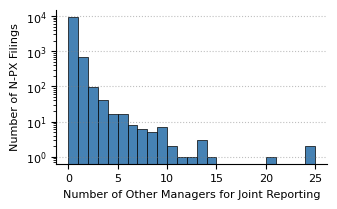

In [23]:
structured_data["formData.summaryPage.otherIncludedManagersCount"].fillna(0).plot(
    kind="hist",
    bins=range(0, 26),
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
    figsize=(3.5, 2),
)
plt.grid(axis="x")
plt.yscale("log")
plt.xlabel("Number of Other Managers for Joint Reporting")
plt.ylabel("Number of N-PX Filings")

## Proxy Voting Records


### Downloading Proxy Voting Records


Around half of the Form N-PX filings include proxy voting records, about 5000 for the 2024 report period.
The following code shows how to download the records using the [Form N-PX Proxy Voting Records API](https://sec-api.io/docs/form-npx-proxy-voting-records-api) in parallel and save them saved as individual files in the directory `./form-npx-proxy-voting-records` as gzipped `json` files.
The files are stored in individual files to avoid memory issues when parsing the data into a pandas data frame.

Downloading the entire dataset may take up to 20 minutes.


In [24]:
accessionNo_with_voting_records = structured_data[
    structured_data["proxyVotingRecordsAttached"] == True
][["accessionNo"]]
accessionNo_with_voting_records = [a[0] for a in accessionNo_with_voting_records.values]
accessionNo_with_voting_records[:5]

['0001213900-24-057688',
 '0001162044-24-000643',
 '0001172661-24-002634',
 '0001104659-24-077743',
 '0001766392-24-000004']

In [25]:
import json

YEARS = range(2025, 2023, -1)  # from 2025 to 2024
DATA_DIR = "./form-npx-proxy-voting-records"

os.makedirs(DATA_DIR, exist_ok=True)


def download_proxy_voting_records(accessionNo):
    try:
        filename = f"{DATA_DIR}/{accessionNo}_proxy_voting_record.json"
        if os.path.exists(filename):
            return accessionNo
        response = formNpxApi.get_voting_records(accessionNo)
        with open(f"{DATA_DIR}/{accessionNo}_proxy_voting_record.json", "w") as outfile:
            json.dump(response, outfile)

        return accessionNo

    except Exception as e:
        print(f"Error downloading {accessionNo}: {e}")
        return None


num_downloaded = len(os.listdir(DATA_DIR))

if num_downloaded < len(accessionNo_with_voting_records):
    print("Downloading proxy voting records...")
    with ThreadPoolExecutor(max_workers=4) as pool:
        downloaded_files = list(
            pool.map(download_proxy_voting_records, accessionNo_with_voting_records)
        )

    num_success_download = len([f for f in downloaded_files if f])

    print(
        f"Finished downloading {num_success_download}/{len(accessionNo_with_voting_records)} proxy voting records."
    )
else:
    print("Files already exists. Skipping download.")

Files already exists. Skipping download.


To load the proxy voting records, we process them file by file.
This process might take several minutes depending on the system.


In [26]:
import pandas as pd
import json
import gzip


def load_json_files(directory, ending=None):
    """
    Load all JSON files from a given directory into a single Pandas DataFrame.

    :param directory: Path to the directory containing JSON files
    :param ending: Optional file ending to filter files
    :return: A concatenated Pandas DataFrame
    """
    dataframes = []

    cnt = 1
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if ending is None or filename.endswith(ending):
                if cnt % 100 == 0:
                    print(cnt)
                cnt += 1
                file_path = os.path.join(root, filename)
                data = {}
                if file_path.endswith(".gz"):
                    with open(file_path, "rb") as file:
                        data = json.loads(gzip.decompress(file.read()).decode())
                else:
                    with open(file_path, "r") as file:
                        data = json.load(file)
                df = pd.json_normalize(data)  # Flatten nested JSON structures
                df = df.drop(columns=["proxyVotingRecordsAttached"])
                df = df.drop(
                    columns=[col for col in df.columns if col.startswith("formData.")]
                )
                df = df.drop(
                    columns=[col for col in df.columns if col.startswith("headerData.")]
                )

                # explode and flatten proxyVotingRecords
                df = df.explode("proxyVotingRecords").reset_index(drop=True)
                df = df.join(pd.json_normalize(df["proxyVotingRecords"])).drop(
                    columns=["proxyVotingRecords"]
                )
                dataframes.append(df)

    if dataframes:
        return pd.concat(dataframes, ignore_index=True)
    else:
        return pd.DataFrame()


proxy_voting_records = load_json_files(DATA_DIR, ending="_proxy_voting_record.json")

print(len(proxy_voting_records))
proxy_voting_records.head()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400


/var/folders/83/7b5245js685cr2ybfzjf9yq00000gn/T/ipykernel_98273/852144156.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dataframes, ignore_index=True)


24159505


,id,accessionNo,formType,filedAt,periodOfReport,cik,ticker,companyName,issuerName,cusip,...,sharesVoted,sharesOnLoan,voteCategories.voteCategory,vote.voteRecord,voteSource,voteSeries,otherVoteDescription,voteOtherInfo,voteManager.otherManagers,figi
0,c98a1580b246d2ff18e1f05fc3089754,0001599814-24-000009,N-PX,2024-08-21T16:28:11-04:00,2024-06-30,1599814,,"Kopernik Global Investors, LLC",Newmont Corporation,651639106,...,1960047.0,0.0,[{'categoryType': 'SECTION 14A SAY-ON-PAY VOTE...,"[{'howVoted': 'FOR', 'sharesVoted': 1960047, '...",NaN,NaN,NaN,NaN,NaN,NaN
1,c98a1580b246d2ff18e1f05fc3089754,0001599814-24-000009,N-PX,2024-08-21T16:28:11-04:00,2024-06-30,1599814,,"Kopernik Global Investors, LLC",Newmont Corporation,NaN,...,4299600.0,0.0,[{'categoryType': 'SECTION 14A SAY-ON-PAY VOTE...,"[{'howVoted': 'FOR', 'sharesVoted': 4299600, '...",NaN,NaN,NaN,NaN,NaN,NaN
2,c98a1580b246d2ff18e1f05fc3089754,0001599814-24-000009,N-PX,2024-08-21T16:28:11-04:00,2024-06-30,1599814,,"Kopernik Global Investors, LLC",Vista Gold Corp.,927926303,...,3421561.0,0.0,[{'categoryType': 'SECTION 14A SAY-ON-PAY VOTE...,"[{'howVoted': 'FOR', 'sharesVoted': 3421561, '...",NaN,NaN,NaN,NaN,NaN,NaN
3,c98a1580b246d2ff18e1f05fc3089754,0001599814-24-000009,N-PX,2024-08-21T16:28:11-04:00,2024-06-30,1599814,,"Kopernik Global Investors, LLC",Air Lease Corporation,00912X302,...,262560.0,0.0,[{'categoryType': 'SECTION 14A SAY-ON-PAY VOTE...,"[{'howVoted': 'FOR', 'sharesVoted': 262560, 'm...",NaN,NaN,NaN,NaN,NaN,NaN
4,c98a1580b246d2ff18e1f05fc3089754,0001599814-24-000009,N-PX,2024-08-21T16:28:11-04:00,2024-06-30,1599814,,"Kopernik Global Investors, LLC",Air Lease Corporation,00912X302,...,262560.0,0.0,[{'categoryType': 'SECTION 14A SAY-ON-PAY VOTE...,"[{'howVoted': 'ONE YEAR', 'sharesVoted': 26256...",NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print(f"Number of proxy voting records = {len(proxy_voting_records):,}")

Number of proxy voting records = 24,159,505


### Vote Categories


In [28]:
voteCategories = pd.json_normalize(
    proxy_voting_records["voteCategories.voteCategory"].explode()
)

In [29]:
count_voteCategory = (
    voteCategories.groupby(voteCategories["categoryType"].str.upper().str.strip())
    .size()
    .to_frame(name="Count")
).rename_axis("Vote Category")
count_voteCategory["Pct"] = (
    count_voteCategory["Count"].astype(int)
    / count_voteCategory["Count"].astype(int).sum()
).map("{:.2%}".format)

count_voteCategory.sort_values(by="Count", ascending=False, inplace=True)
count_voteCategory["Count"] = count_voteCategory["Count"].map(lambda x: f"{x:,}")

print(f"Number of Voting Records including specific Vote Category (2024)\n")

count_voteCategory.head(14)

Number of Voting Records including specific Vote Category (2024)



,Count,Pct
Vote Category,,
DIRECTOR ELECTIONS,"12,496,733",49.20%
CORPORATE GOVERNANCE,"3,179,135",12.52%
SECTION 14A SAY-ON-PAY VOTES,"3,042,315",11.98%
COMPENSATION,"1,855,067",7.30%
CAPITAL STRUCTURE,"1,740,006",6.85%
AUDIT-RELATED,"1,598,387",6.29%
OTHER,"458,403",1.80%
OTHER SOCIAL ISSUES,"307,159",1.21%
ENVIRONMENT OR CLIMATE,"205,512",0.81%


### Shares on Loan


In [30]:
## compare the number of sharesOnLoan to number of sharesVoted on a company by company basis

shares_voted_and_on_loan = proxy_voting_records[
    ["cusip", "sharesVoted", "sharesOnLoan"]
]
shares_voted_and_on_loan.loc[:, "pctSharesVoted"] = (
    shares_voted_and_on_loan["sharesOnLoan"] / shares_voted_and_on_loan["sharesVoted"]
)

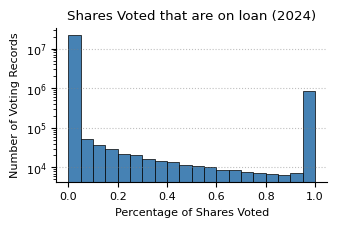

In [31]:
shares_voted_and_on_loan["pctSharesVoted"].clip(0, 1).plot(
    kind="hist",
    bins=20,
    color="steelblue",
    edgecolor="black",
    linewidth=0.5,
    figsize=(3.5, 2),
)
plt.grid(axis="x")
plt.title("Shares Voted that are on loan (2024)")
plt.xlabel("Percentage of Shares Voted")
plt.ylabel("Number of Voting Records")
plt.yscale("log")

### Distribution of votes among filers


In [32]:
# prepare a mapping from cik to company name
df_cik_names = structured_data[["cik", "companyName"]].drop_duplicates(["cik"])
company_names_by_cik = {}
for row in df_cik_names.values:
    company_names_by_cik[f"{row[0]}"] = row[1]


def get_company_name(cik):
    return company_names_by_cik.get(f"{cik}", "Unknown")

In [33]:
count_voteByFiler = (
    proxy_voting_records.groupby(proxy_voting_records["cik"])
    .size()
    .to_frame(name="Count")
).rename_axis("Filer")
count_voteByFiler["Pct"] = (
    count_voteByFiler["Count"].astype(int)
    / count_voteByFiler["Count"].astype(int).sum()
).map("{:.2%}".format)

count_voteByFiler.sort_values(by="Count", ascending=False, inplace=True)
count_voteByFiler["Count"] = count_voteByFiler["Count"].map(lambda x: f"{x:,}")

count_voteByFiler.index = count_voteByFiler.index.map(
    lambda x: f"{get_company_name(x)} ({x})"
)

print(f"Number of Voting Records by Company (2024)\n")

count_voteByFiler.head(15)

Number of Voting Records by Company (2024)



,Count,Pct
Filer,,
iSHARES TRUST (1100663),"1,141,559",4.73%
"iShares, Inc. (930667)","513,592",2.13%
DFA INVESTMENT DIMENSIONS GROUP INC (355437),"486,275",2.01%
EQ ADVISORS TRUST (1027263),"474,574",1.96%
Dimensional ETF Trust (1816125),"468,237",1.94%
AMERICAN CENTURY ETF TRUST (1710607),"440,665",1.82%
FIDELITY SALEM STREET TRUST (35315),"429,877",1.78%
VANGUARD INTERNATIONAL EQUITY INDEX FUNDS (857489),"401,343",1.66%
SPDR INDEX SHARES FUNDS (1168164),"386,458",1.60%


### Votes for specific company - example Tesla

In this section, we aggregate all reported proxy votes for a specific company as identified by its ticker symbol.

Form N-PX proxy voting records do not include the ticker symbol of the company holding the shareholder meeting, so we first obtain cusip via the [sec-api.io Mapping API](https://sec-api.io/docs/mapping-api) and then query for all records with the given cusip.


In [34]:
from sec_api import MappingApi

mappingApi = MappingApi(api_key="YOUR_API_KEY")

cusip_tesla = mappingApi.resolve("ticker", "^TSLA$")[0]["cusip"]
print(cusip_tesla)

proxyVotes_tesla = proxy_voting_records[proxy_voting_records["cusip"] == cusip_tesla]

88160R101


Extract the proxy voting records for which the meeting date matches the 2024 shareholder meeting date of June, 6.


In [35]:
# extract meetingYear, meetingMonth, meetingDay from meetingDate
proxyVotes_tesla.loc[:, "meetingYear"] = pd.to_numeric(
    proxyVotes_tesla["meetingDate"].str.extract(r"(\d{1,2})/(\d{1,2})/(\d{2,4})")[2],
    errors="coerce",
).astype("Int64")
# add 2000 to meeting years less than 100
proxyVotes_tesla.loc[:, "meetingYear"] = proxyVotes_tesla["meetingYear"].apply(
    lambda x: x + 2000 if x < 100 else x
)
proxyVotes_tesla.loc[:, "meetingMonth"] = pd.to_numeric(
    proxyVotes_tesla["meetingDate"].str.extract(r"(\d{1,2})/(\d{1,2})/(\d{2,4})")[0],
    errors="coerce",
).astype("Int64")

proxyVotes_tesla.loc[:, "meetingDay"] = pd.to_numeric(
    proxyVotes_tesla["meetingDate"].str.extract(r"(\d{1,2})/(\d{1,2})/(\d{2,4})")[1],
    errors="coerce",
).astype("Int64")

In [36]:
# count the number of values of meetingDate
count_meetingDate_tesla = (
    proxyVotes_tesla.groupby(["meetingYear", "meetingMonth", "meetingDay"])
    .size()
    .to_frame(name="Count")
    .reset_index()
)
count_meetingDate_tesla.sort_values(
    "Count", ascending=False, inplace=True, ignore_index=True
)

print(
    f"Number of Proxy Voting Records by Meeting Date for Tesla shareholder meeting (2024)\n"
)
count_meetingDate_tesla.head(10)

Number of Proxy Voting Records by Meeting Date for Tesla shareholder meeting (2024)



,meetingYear,meetingMonth,meetingDay,Count
0,2024,6,13,17941
1,2024,6,14,64
2,2024,6,12,15
3,2024,13,6,15
4,2024,5,13,14
5,2024,4,15,13
6,2023,5,16,6
7,2024,5,15,6
8,2024,5,26,5
9,2024,6,24,5


In [37]:
# only keep rows in meetings_tesla where the meetingYear is 2024, meetingDay is 13, and meetingMonth is 6
proxyVotes_tesla = proxyVotes_tesla[
    (proxyVotes_tesla["meetingYear"] == 2024)
    & (proxyVotes_tesla["meetingMonth"] == 6)
    & (proxyVotes_tesla["meetingDay"] == 13)
]

Some of the proxy voting records contain erroneous values for the number of shares voted, off by a factor of a 1,000,000.
For the present demonstration, we will therefore simply ignore all voting records from companies for which an N-PX/A filing was published in 2024, indicating that there were errors in the original filing.


In [38]:
# first get ciks for which an N-PX/A filing was made indicating errors in the initial filing
ciks_with_errors = structured_data[structured_data["formType"] == "N-PX/A"][
    "cik"
].unique()

proxyVotes_tesla = proxyVotes_tesla[~proxyVotes_tesla["cik"].isin(ciks_with_errors)]
len(proxyVotes_tesla)

17941

In [39]:
count_voteByFiler_tesla = (
    proxyVotes_tesla.groupby(proxyVotes_tesla["cik"]).size().to_frame(name="Count")
).rename_axis("Filer")

# store a dict for later
vote_count_by_cik_tesla = count_voteByFiler_tesla["Count"].to_dict()

count_voteByFiler_tesla["Pct"] = (
    count_voteByFiler_tesla["Count"].astype(int)
    / count_voteByFiler_tesla["Count"].astype(int).sum()
).map("{:.2%}".format)

count_voteByFiler_tesla.sort_values(by="Count", ascending=False, inplace=True)
count_voteByFiler_tesla["Count"] = count_voteByFiler_tesla["Count"].map(
    lambda x: f"{x:,}"
)
count_voteByFiler_tesla.index = count_voteByFiler_tesla.index.map(
    lambda x: f"{get_company_name(x)} ({x})"
)

print(f"Number of Proxy Voting Records by Filer for Tesla shareholder meeting (2024)\n")

count_voteByFiler_tesla.head(15)

Number of Proxy Voting Records by Filer for Tesla shareholder meeting (2024)



,Count,Pct
Filer,,
iSHARES TRUST (1100663),481,2.68%
Global X Funds (1432353),468,2.61%
EQ ADVISORS TRUST (1027263),312,1.74%
Natixis Funds Trust IV (1095726),286,1.59%
ADVANCED SERIES TRUST (814679),273,1.52%
JNL SERIES TRUST (933691),221,1.23%
RUSSELL INVESTMENT CO (351601),195,1.09%
SPDR SERIES TRUST (1064642),195,1.09%
PROSHARES TRUST (1174610),169,0.94%


Some companies misreported their number of voted shares by a factor of 1,000,000 and have not filed an amendment yet, so they are still part of the dataframe. These were all small funds, but due to erroneous reporting, they appeared as the largest funds.

As a simple remedy, we ignore them by requesting that the fund reported at least 10 voting records for the Tesla shareholder meeting.


In [40]:
# apply the counts for filtering
proxyVotes_tesla["voteCount"] = proxyVotes_tesla["cik"].apply(
    lambda x: vote_count_by_cik_tesla[x]
)

In [41]:
proxyVotes_tesla = proxyVotes_tesla[proxyVotes_tesla["voteCount"] > 10]

In [42]:
count_numberOfVotesByFiler_tesla = (
    proxyVotes_tesla.groupby("cik").agg({"sharesVoted": "sum"})
).rename_axis("Fund")
count_numberOfVotesByFiler_tesla["Pct"] = (
    count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int)
    / count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int).sum()
).map("{:.2%}".format)

# count_numberOfVotesByFiler_tesla.sort_values(by="Count", ascending=False, inplace=True)
count_numberOfVotesByFiler_tesla.sort_values(
    by="sharesVoted", ascending=False, inplace=True
)
count_numberOfVotesByFiler_tesla["sharesVoted"] = count_numberOfVotesByFiler_tesla[
    "sharesVoted"
].map(lambda x: f"{int(round(x)):,}")

count_numberOfVotesByFiler_tesla.index = count_numberOfVotesByFiler_tesla.index.map(
    lambda x: f"{get_company_name(x)} ({x})"
)


print(f"Number of Shares Voted by Fund at Tesla shareholder meeting (2024)\n")

count_numberOfVotesByFiler_tesla.head(15)

Number of Shares Voted by Fund at Tesla shareholder meeting (2024)



,sharesVoted,Pct
Fund,,
WisdomTree Digital Trust (1859001),"5,681,011,765",42.84%
VANGUARD INDEX FUNDS (36405),"2,392,883,220",18.04%
iSHARES TRUST (1100663),"743,331,807",5.61%
FIDELITY CONCORD STREET TRUST (819118),"599,545,440",4.52%
GROWTH FUND OF AMERICA (44201),"282,407,489",2.13%
VANGUARD INSTITUTIONAL INDEX FUNDS (862084),"258,425,752",1.95%
SELECT SECTOR SPDR TRUST (1064641),"195,788,203",1.48%
BARON SELECT FUNDS (1217673),"159,618,758",1.20%
NEW PERSPECTIVE FUND (71516),"138,173,009",1.04%


#### Voting behavior of large funds


In [43]:
# aggregate the AGAINST, FOR, ABSTAIN, and WITHHOLD votes for each row in proxyVotes_tesla, strip the strings and convert to uppercase
for voteDirection in ["For", "Against", "Abstain", "Withhold"]:
    proxyVotes_tesla[f"sharesVoted{voteDirection}"] = proxyVotes_tesla[
        "vote.voteRecord"
    ].apply(
        lambda x: (
            0
            if isinstance(x, float)
            else sum(
                [
                    (
                        vote["sharesVoted"]
                        if "howVoted" in vote
                        and "sharesVoted" in vote
                        and vote["howVoted"].strip().upper() == voteDirection.upper()
                        else 0
                    )
                    for vote in x
                ]
            )
        )
    )
    proxyVotes_tesla[f"sharesVoted{voteDirection}Pct"] = (
        proxyVotes_tesla[f"sharesVoted{voteDirection}"]
        / proxyVotes_tesla["sharesVoted"]
    ).map("{:.2%}".format)
# count the number of votes that were cast in favor of management suggestion
# only count votes where the management recommendation is FOR or AGAINST
proxyVotes_tesla[f"sharesVotedWithManagement"] = proxyVotes_tesla[
    "vote.voteRecord"
].apply(
    lambda x: (
        0
        if isinstance(x, float)
        else sum(
            [
                (
                    vote["sharesVoted"]
                    if "howVoted" in vote
                    and "sharesVoted" in vote
                    and "managementRecommendation" in vote
                    and vote["managementRecommendation"].strip().upper()
                    in ["FOR", "AGAINST"]
                    and vote["howVoted"].strip().upper()
                    == vote["managementRecommendation"].strip().upper()
                    else 0
                )
                for vote in x
            ]
        )
    )
)
proxyVotes_tesla[f"sharesVotedWithManagementPct"] = (
    proxyVotes_tesla[f"sharesVotedWithManagement"] / proxyVotes_tesla["sharesVoted"]
).map("{:.2%}".format)

In [44]:
# check if the votes are cast either all for for, against, abstain, or withhold
# i.e. check if any of the rows of sharesVotedFor, sharesVotedAgainst, sharesVotedAbstain, sharesVotedWithhold are equal to sharesVoted
proxyVotes_tesla.loc[:, "unidirectionalVote"] = proxyVotes_tesla[
    "sharesVoted"
] == proxyVotes_tesla[
    [
        "sharesVotedFor",
        "sharesVotedAgainst",
        "sharesVotedAbstain",
        "sharesVotedWithhold",
    ]
].sum(
    axis=1
)

print("Number of Unidirectional Votes by Funds at the 2024 Tesla Shareholder Meeting")
proxyVotes_tesla["unidirectionalVote"].value_counts()

Number of Unidirectional Votes by Funds at the 2024 Tesla Shareholder Meeting


unidirectionalVote
True     16067
False      161
Name: count, dtype: int64

The following code explores the voting behavior of the largest funds at the Tesla shareholder meeting 2024.
The exploration is based on the number of shares voted and focus on the votes cast for or against proposals, abstained and withhold votes.
Additionally, the percentage of voted shares in accordance with management suggestions is analyzed. Note that the number of shares is summed over all proposals, thus, the number of shares voted does not represent the number of shares held by the fund.


In [45]:
count_numberOfVotesByFiler_tesla = (
    proxyVotes_tesla.groupby(proxyVotes_tesla["cik"]).agg(
        {
            "sharesVoted": "sum",
            "sharesVotedFor": "sum",
            "sharesVotedAgainst": "sum",
            "sharesVotedAbstain": "sum",
            "sharesVotedWithhold": "sum",
            "sharesVotedWithManagement": "sum",
        }
    )
).rename_axis("Fund")

count_numberOfVotesByFiler_tesla["Pct"] = (
    count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int)
    / count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int).sum()
).map("{:.2%}".format)

for voteDirection in ["For", "Against", "Abstain", "Withhold", "WithManagement"]:
    count_numberOfVotesByFiler_tesla[f"Vote{voteDirection}Pct"] = (
        count_numberOfVotesByFiler_tesla[f"sharesVoted{voteDirection}"].astype(int)
        / count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int)
    ).map("{:.2%}".format)

count_numberOfVotesByFiler_tesla["Pct"] = (
    count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int)
    / count_numberOfVotesByFiler_tesla["sharesVoted"].astype(int).sum()
).map("{:.2%}".format)

# count_numberOfVotesByFiler_tesla.sort_values(by="Count", ascending=False, inplace=True)
count_numberOfVotesByFiler_tesla.sort_values(
    by="sharesVoted", ascending=False, inplace=True
)
count_numberOfVotesByFiler_tesla["sharesVoted"] = count_numberOfVotesByFiler_tesla[
    "sharesVoted"
].map(lambda x: f"{int(round(x)):,}")
count_numberOfVotesByFiler_tesla.index = count_numberOfVotesByFiler_tesla.index.map(
    lambda x: f"{get_company_name(x)} ({x})"
)


print(f"Direction of Votes by Company at Tesla Shareholder Meeting (2024)\n")

count_numberOfVotesByFiler_tesla[
    [
        "sharesVoted",
        "Pct",
        "VoteForPct",
        "VoteAgainstPct",
        "VoteWithholdPct",
        "VoteAbstainPct",
        "VoteWithManagementPct",
    ]
].head(40)

Direction of Votes by Company at Tesla Shareholder Meeting (2024)



,sharesVoted,Pct,VoteForPct,VoteAgainstPct,VoteWithholdPct,VoteAbstainPct,VoteWithManagementPct
Fund,,,,,,,
WisdomTree Digital Trust (1859001),"5,681,011,765",42.84%,61.54%,38.46%,0.00%,0.00%,46.15%
VANGUARD INDEX FUNDS (36405),"2,392,883,220",18.04%,61.54%,38.46%,0.00%,0.00%,46.15%
iSHARES TRUST (1100663),"743,331,807",5.61%,61.51%,38.49%,0.00%,0.00%,46.15%
FIDELITY CONCORD STREET TRUST (819118),"599,545,440",4.52%,61.54%,38.46%,0.00%,0.00%,46.15%
GROWTH FUND OF AMERICA (44201),"282,407,489",2.13%,58.45%,41.55%,0.00%,0.00%,46.15%
VANGUARD INSTITUTIONAL INDEX FUNDS (862084),"258,425,752",1.95%,61.54%,38.46%,0.00%,0.00%,46.15%
SELECT SECTOR SPDR TRUST (1064641),"195,788,203",1.48%,30.77%,69.23%,0.00%,0.00%,46.15%
BARON SELECT FUNDS (1217673),"159,618,758",1.20%,61.54%,38.46%,0.00%,0.00%,46.15%
NEW PERSPECTIVE FUND (71516),"138,173,009",1.04%,61.31%,38.69%,0.00%,0.00%,46.15%
